In [1]:
## Sort out Climate Ipynb

In [23]:
import numpy as np
import scipy as sc
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import sklearn


from sklearn.mixture import GaussianMixture
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.preprocessing import normalize

from sklearn.metrics import silhouette_score
from sklearn.metrics import davies_bouldin_score

from sklearn.mixture import GaussianMixture
from sklearn.cluster import SpectralClustering

from sklearn.manifold import Isomap
import umap
from umap import UMAP
from sklearn.decomposition import PCA


# Dataset

In [4]:
Climate_Basel_datfram = pd.read_csv("C:\Data\ClimateDataBasel.csv")

column_names = Climate_Basel_datfram.columns = [
    'Temperature (Min) ℃', 'Temperature (Max) ℃', 'Temperature (Mean) ℃',
    'Relative Humidity (Min) %', 'Relative Humidity (Max) %', 'Relative Humidity (Mean) %',
    'Sea Level Pressure (Min) hPa', 'Sea Level Pressure (Max) hPa', 'Sea Level Pressure (Mean) hPa',
    'Precipitation Total mm', 'Snowfall Amount cm', 'Sunshine Duration min',
    'Wind Gust (Min) Km/h', 'Wind Gust (Max) Km/h', 'Wind Gust (Mean) Km/h',
    'Wind Speed (Min) Km/h', 'Wind Speed (Max) Km/h', 'Wind Speed (Mean) Km/h']

CB = Climate_Basel_datfram

## Dropping columns

In [7]:
col_dropped = ['Temperature (Min) ℃', 'Temperature (Max) ℃',
               'Relative Humidity (Min) %', 'Relative Humidity (Max) %',
               'Sea Level Pressure (Min) hPa', 'Sea Level Pressure (Max) hPa',
               'Wind Gust (Min) Km/h', 'Wind Gust (Max) Km/h',
               'Wind Speed (Min) Km/h', 'Wind Speed (Max) Km/h']


CB_dropped = Climate_Basel_datfram.drop(col_dropped, axis = 1)

## or this data set

In [45]:
df = pd.read_csv("C:\Data\ClimateDataBasel.csv")

col_names = df.columns = [
    'Temperature (Min) ℃', 'Temperature (Max) ℃', 'Temperature (Mean) ℃',
    'Relative Humidity (Min) %', 'Relative Humidity (Max) %', 'Relative Humidity (Mean) %',
    'Sea Level Pressure (Min) hPa', 'Sea Level Pressure (Max) hPa', 'Sea Level Pressure (Mean) hPa',
    'Precipitation Total mm', 'Snowfall Amount cm', 'Sunshine Duration min',
    'Wind Gust (Min) Km/h', 'Wind Gust (Max) Km/h', 'Wind Gust (Mean) Km/h',
    'Wind Speed (Min) Km/h', 'Wind Speed (Max) Km/h', 'Wind Speed (Mean) Km/h']

In [46]:
features_to_use = [
    'Temperature (Mean) ℃',
    'Relative Humidity (Mean) %',
    'Sea Level Pressure (Mean) hPa',
    'Precipitation Total mm', 
    'Snowfall Amount cm', 
    'Sunshine Duration min',
    'Wind Gust (Mean) Km/h',
    'Wind Speed (Mean) Km/h'
]


# Created dataframe with selected features and handle any NaNs
df_selected = df[features_to_use].dropna()

## Pearson Correlation

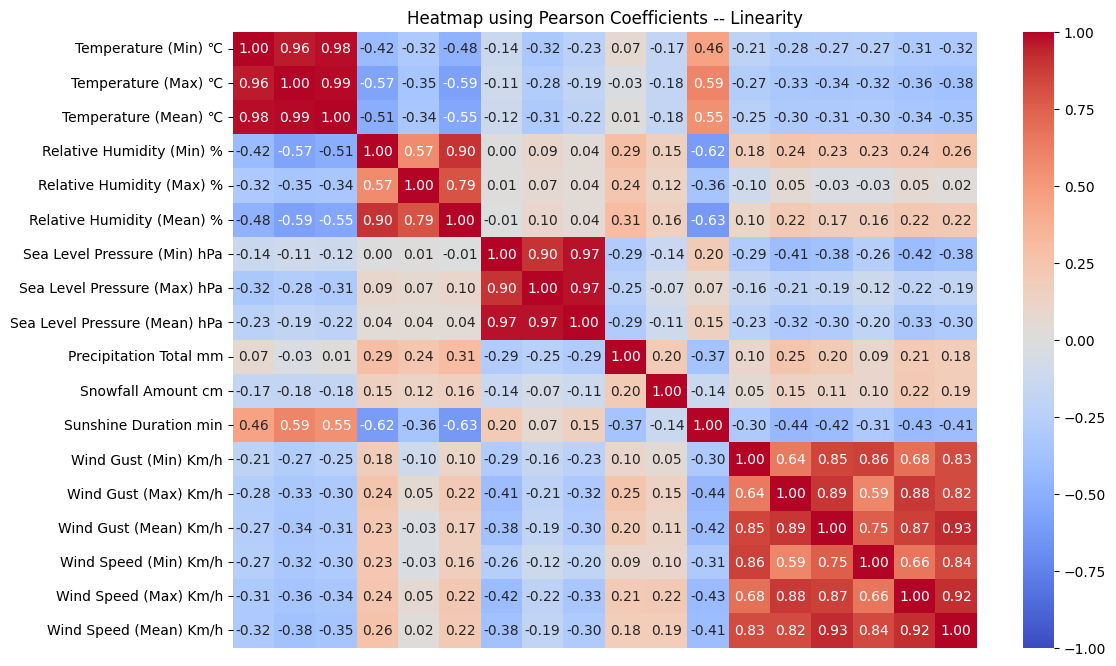

In [8]:
# Compute the Pearson correlation matrix
pearson_corr = CB.corr(method='pearson')

# Plot the heatmap
plt.figure(figsize=(12, 8))  # Adjust the figure size as needed
sns.heatmap(pearson_corr, annot=True, fmt=".2f", cmap='coolwarm', vmin=-1, vmax=1, xticklabels=False)
plt.title("Heatmap using Pearson Coefficients -- Linearity")

plt.savefig('Pearsons_Coefficients.pdf')

plt.show()

## Missing Data

In [9]:
# Check for missing data in each column
missing_data_summary = CB.isnull().sum()

# Filter to include only columns with missing data
missing_data_summary = missing_data_summary[missing_data_summary > 0]

# Calculate the percentage of missing data
missing_data_percentage = (missing_data_summary / CB.shape[0]) * 100

# Combine into a DataFrame
missing_data_report = pd.DataFrame({
    'Missing Values': missing_data_summary,
    'Percentage (%)': missing_data_percentage
})

# Display the report
print(missing_data_report)

Empty DataFrame
Columns: [Missing Values, Percentage (%)]
Index: []


In [11]:
def filling_zeros(data):
    
    numerical_data = data.select_dtypes(include=[np.number])
    zeros = data.fillna(numerical_data.mean())
    
    return data
    
cb_miss = filling_zeros(CB_dropped)
# Not any but useful if there comes a data frame with missing values

## Outliers

In [48]:
def find_outliers(data):
    
    cleaned = data.copy()

    # select a number in the columns
    # np.number --> every type of number
    
    for i in data.select_dtypes(include=[np.number]).columns:
        Q1 = data[i].quantile(0.25)
        Q3 = data[i].quantile(0.75)
        # Interquartile Range Equation
        IQR = Q3 - Q1
        
        lo_outliers = Q1 - 1.5*IQR
        hi_outliers = Q3 + 1.5*IQR
    
        # Remove outliers from data set
        outliers = (data[i] < lo_outliers) | (data[i] > hi_outliers)
        
    cleaned = cleaned[~outliers]
        
        
    return cleaned


clean = find_outliers(cb_miss)

## Standardise

In [15]:
def standardise(data):
    # this is the standardise scaler
    scaler = StandardScaler()

    # could use np.number but no need, so use float or integer
    numerical_data = data.select_dtypes(include=['float64', 'int64'])

    # fit the data on the numerical columns
    data_scaled = scaler.fit_transform(numerical_data)
    
    # standardise
    df_standardised = pd.DataFrame(data_scaled, columns=data.columns)    
    return df_standardised

CB_standardise = standardise(clean)

## Normalise

In [16]:
def normalise(data):
    # normalise scaler
    scaler = MinMaxScaler()

    # could use np.number but no need, so use float or integer
    numerical_data = data.select_dtypes(include=['float64', 'int64'])

    # fit the data on the numerical columns
    data_scaled = scaler.fit_transform(numerical_data)

    # normalise
    df_normalised = pd.DataFrame(data_scaled, columns=data.columns)    
    return df_normalised

CB_normalise   = normalise(clean)

# Dimensionality Reduction

## PCA

In [18]:
def perform_pca(data, n_components):
    numerical_data = data.select_dtypes(include=['float64', 'int64'])

    # Using PCA
    pca_df = PCA(n_components=n_components)
    principalComponents = pca_df.fit_transform(numerical_data)

    # PCA dataframe to plot
    columns = [f'Principal Comp {i + 1}' for i in range(n_components)]
    dataframe_pca = pd.DataFrame(principalComponents,columns=columns)
    
    if n_components == 2:
        plt.figure(figsize=(10, 6))
        plt.scatter(dataframe_pca.iloc[:,0], dataframe_pca.iloc[:,1], s = 5)
        plt.xlabel("PC 1")
        plt.ylabel("PC 2")
        plt.grid(True)
        plt.show()
    
    else:
        raise ValueError(' 2 dimensions is best')
    
    return dataframe_pca

clean_normalise = find_outliers(CB_normalise)

## Isomap

In [25]:
def perform_isomap(data, n_components=2, n_neighbors=5):
    # Using Isomap
    isomap = Isomap(n_components=n_components, n_neighbors=n_neighbors)
    isomap_result = isomap.fit_transform(data)

    # Plot
    plt.figure(figsize=(10, 6))
    plt.scatter(isomap_result[:, 0], isomap_result[:, 1], s=10)
    plt.title("Isomap Visualisation")
    plt.xlabel("Isomap 1")
    plt.ylabel("Isomap 2")
    plt.grid(True)
    plt.show()
    return isomap_result

## UMAP

In [26]:
def umap_(data, n_components= 2):
    numerical_data = data.select_dtypes(include=['float64', 'int64'])

    # Using UMAP
    UMAP_df = UMAP(n_components=n_components, random_state=42)
    UMAP_comps = UMAP_df.fit_transform(numerical_data)

    # Create a UMAP Data frame to plot
    columns = [f'UMAP {i + 1}' for i in range(n_components)]
    dataframe_UMAP = pd.DataFrame(UMAP_comps,columns=columns)

    # Plot the UMAP
    if n_components == 2:
        plt.figure(figsize=(10, 6))
        plt.scatter(dataframe_UMAP.iloc[:,0], dataframe_UMAP.iloc[:,1], s = 5)
        plt.xlabel("UMAP 1")
        plt.ylabel("UMAP 2")
        plt.grid(True)
        plt.show()
    
    else:
        raise ValueError(' 2 dimensions is best')
    
    return dataframe_UMAP

# Clustering

## GMM

In [30]:
def GMM(data, n_clusters = 3):
    # GMM clusters here (using minimal inputs)
    gmm = GaussianMixture(n_components=n_clusters, random_state=42)
    gmm_labels = gmm.fit_predict(data)
    
    return gmm_labels


gmm = GMM(pca_norm)

## Spectral

In [31]:
def Spectral(data, n_clusters = 3):
    # Spectral clusters here 
    # 'nearest_neighbors' is chosen for affinity because it constructs the graph 
    # based on k-nearest neighbors. This method ensures local relationships 
    # between data points are preserved, which is effective for out dataset
    # as it has some non-linear relaitonships
    spectral = SpectralClustering(n_clusters=n_clusters, affinity='nearest_neighbors', random_state=42)
    spectral_labels = spectral.fit_predict(data)
    
    return spectral_labels

spectral = Spectral(pca_norm)

## Kmeans

In [32]:
def Kmeans(data, n_clusters = 3):
    kmeans = KMeans(n_clusters=n_clusters, init='k-means++', random_state=42)
    kmean_labels = kmeans.fit_predict(data)
    
    return kmean_labels

## Plotting the Clusters

In [33]:
def plot_clusters(data, labels, title, feature_labels):
    # plotting clusters using labels provided in inputs
    plt.figure(figsize=(10, 6))
    plt.scatter(data[:, 0], data[:, 1], c=labels, cmap='tab10', s=10)
    plt.xlabel(f'{feature_labels} 1')
    plt.ylabel(f'{feature_labels} 2')
    plt.title(title)
    plt.grid(True)
    plt.show()

# Metrics for Clustering

## Silhouette Score

In [34]:
def sil_score(data, cluster_labels, cluster_type):
    score = silhouette_score(data, cluster_labels, metric='euclidean')
    print(f"Silhouette Score for {cluster_type} : {score:.3f}")

## DB-index

In [35]:
def db_index(data, labels, cluster_type):
    dbi = davies_bouldin_score(data, labels)
    print(f"Davies-Bouldin Index ({cluster_type}): {dbi:.3f}")

# Results

## PCA

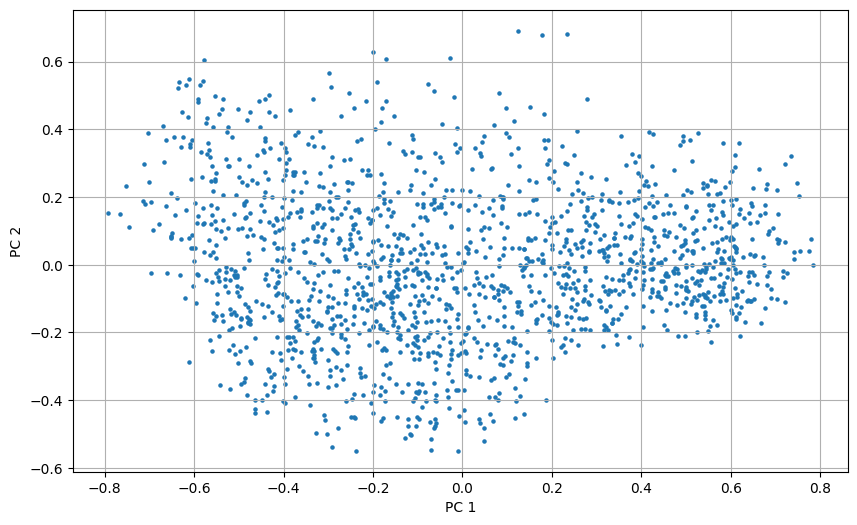

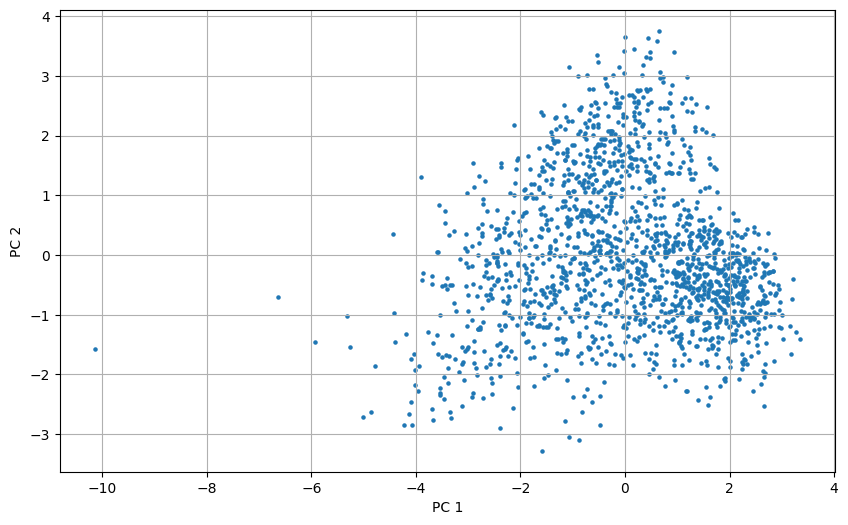

In [40]:
# Preparing and Pre-Processing
CB_standardise = standardise(clean)
CB_normalise   = normalise(clean)

# Removing outliers and performing PCA
clean_normalise   = find_outliers(CB_normalise)
clean_standardise = find_outliers(CB_standardise)
pca_norm = perform_pca(clean_normalise, n_components  =  2)
pca_stnd = perform_pca(CB_standardise,n_components =  2)

# Spectral Clustering and GMM on normalised data (also Kmean)
sn_2 = Spectral(pca_norm, n_clusters=2)
kn_2 = Kmeans(pca_norm, n_clusters=2)
gn_2 = GMM(pca_norm, n_clusters=2)

# Spectral Clustering and GMM on standardised data (also Kmeans)
ss_2 = Spectral(pca_stnd, n_clusters=2)
ks_2 = Kmeans(pca_stnd, n_clusters=2)
gs_2 = GMM(pca_stnd, n_clusters=2)

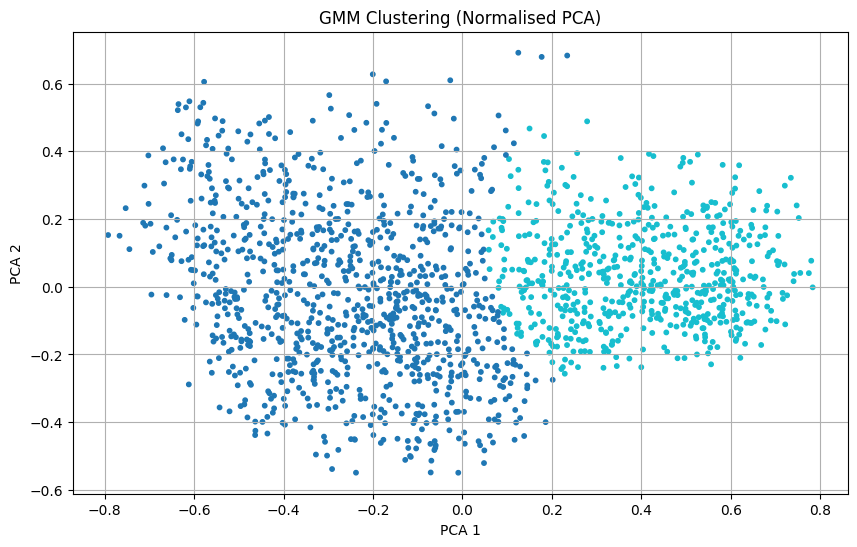

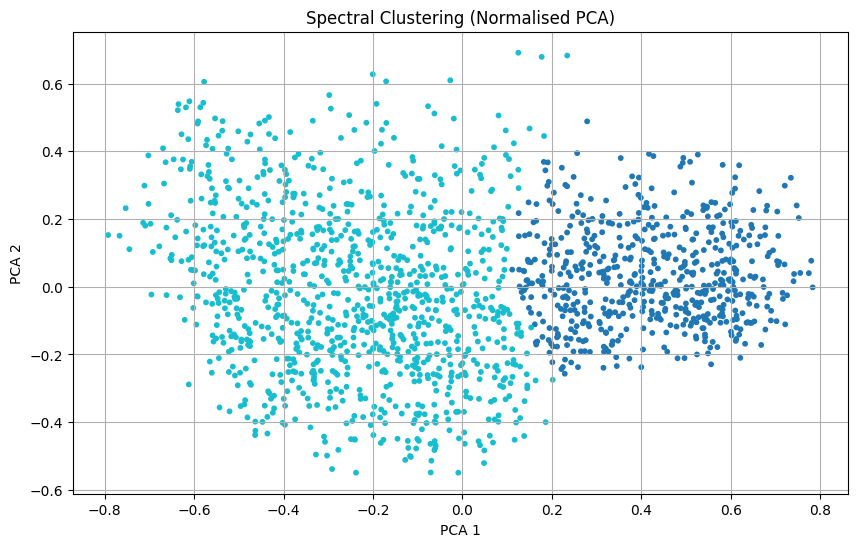

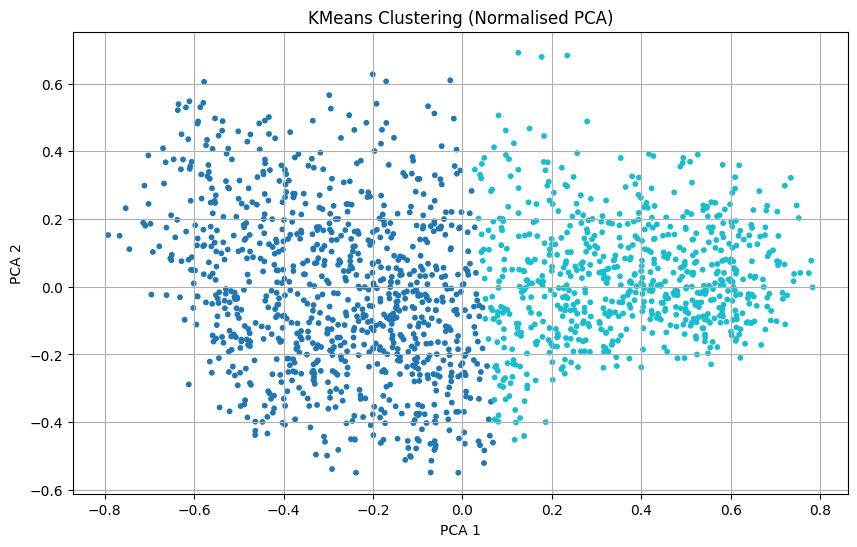

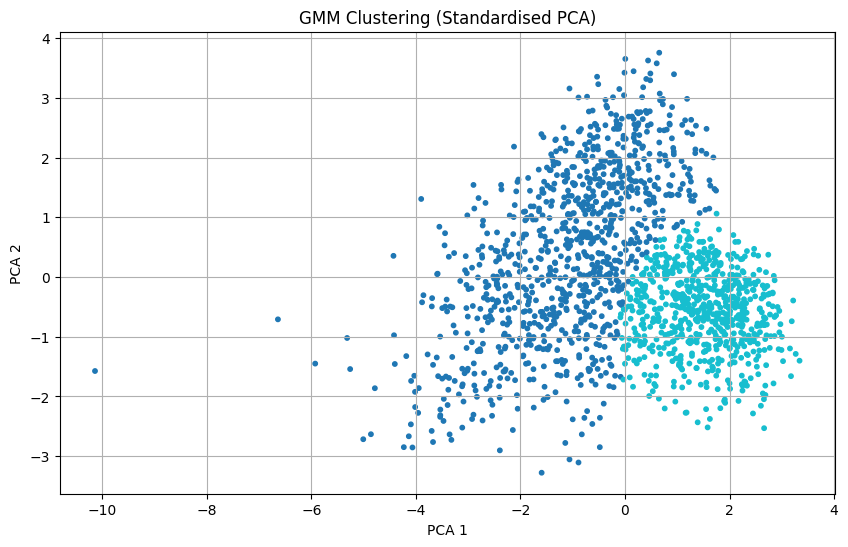

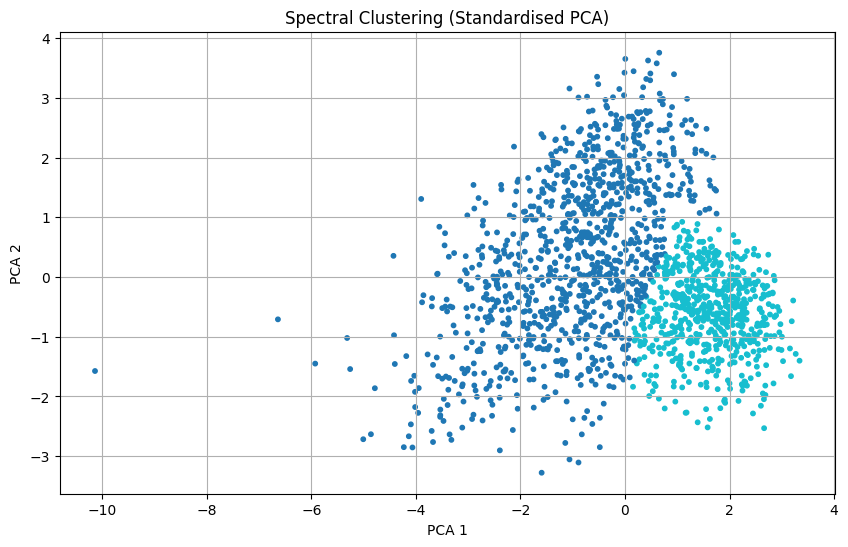

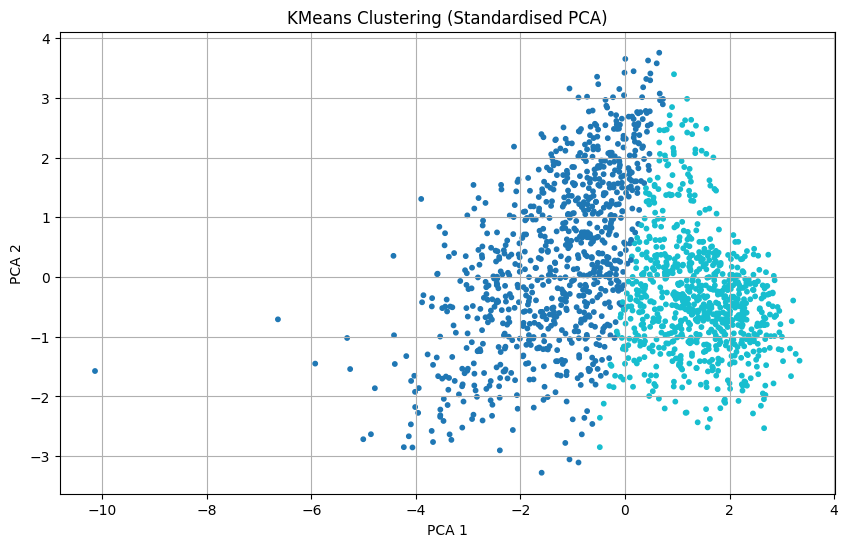

Silhouette Score for GMM (Normalised PCA) : 0.470
Silhouette Score for Spectral (Normalised PCA) : 0.468
Silhouette Score for KMeans (Normalised PCA) : 0.472
Silhouette Score for GMM (Standardised PCA) : 0.393
Silhouette Score for Spectral (Standardised PCA) : 0.386
Silhouette Score for KMeans (Standardised PCA) : 0.403
Davies-Bouldin Index (GMM (Standardised PCA)): 0.951
Davies-Bouldin Index (Spectral (Standardised PCA)): 0.918
Davies-Bouldin Index (KMeans (Standardised PCA)): 0.980
Davies-Bouldin Index (GMM (Normalised PCA)): 0.767
Davies-Bouldin Index (Spectral (Normalised PCA)): 0.752
Davies-Bouldin Index (KMeans (Normalised PCA)): 0.790


In [41]:
# Plot clusters for normalised PCA data
plot_clusters(pca_norm.values, gn_2, 'GMM Clustering (Normalised PCA)', 'PCA')
plot_clusters(pca_norm.values, sn_2, 'Spectral Clustering (Normalised PCA)', 'PCA')
plot_clusters(pca_norm.values, kn_2, 'KMeans Clustering (Normalised PCA)', 'PCA')

# Plot clusters for standardised PCA data
plot_clusters(pca_stnd.values, gs_2, 'GMM Clustering (Standardised PCA)', 'PCA')
plot_clusters(pca_stnd.values, ss_2, 'Spectral Clustering (Standardised PCA)', 'PCA')
plot_clusters(pca_stnd.values, ks_2, 'KMeans Clustering (Standardised PCA)', 'PCA')

# Calculate Silhouette Scores for normalised PCA data
sil_score(pca_norm, gn_2, 'GMM (Normalised PCA)')
sil_score(pca_norm, sn_2, 'Spectral (Normalised PCA)')
sil_score(pca_norm, kn_2, 'KMeans (Normalised PCA)')

# Calculate Silhouette Scores for standardised PCA data
sil_score(pca_stnd, gs_2, 'GMM (Standardised PCA)')
sil_score(pca_stnd, ss_2, 'Spectral (Standardised PCA)')
sil_score(pca_stnd, ks_2, 'KMeans (Standardised PCA)')

# Calculate Davies-Bouldin Index for standardised PCA data
db_index(pca_stnd, gs_2, 'GMM (Standardised PCA)')
db_index(pca_stnd, ss_2, 'Spectral (Standardised PCA)')
db_index(pca_stnd, ks_2, 'KMeans (Standardised PCA)')

# Calculate Davies-Bouldin Index for standardised PCA data
db_index(pca_norm, gn_2, 'GMM (Normalised PCA)')
db_index(pca_norm, sn_2, 'Spectral (Normalised PCA)')
db_index(pca_norm, kn_2, 'KMeans (Normalised PCA)')


## Isomap

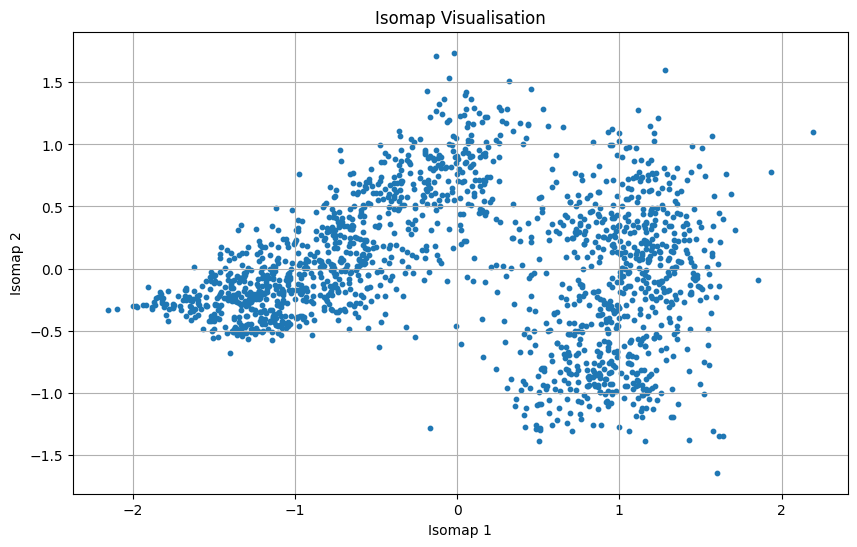

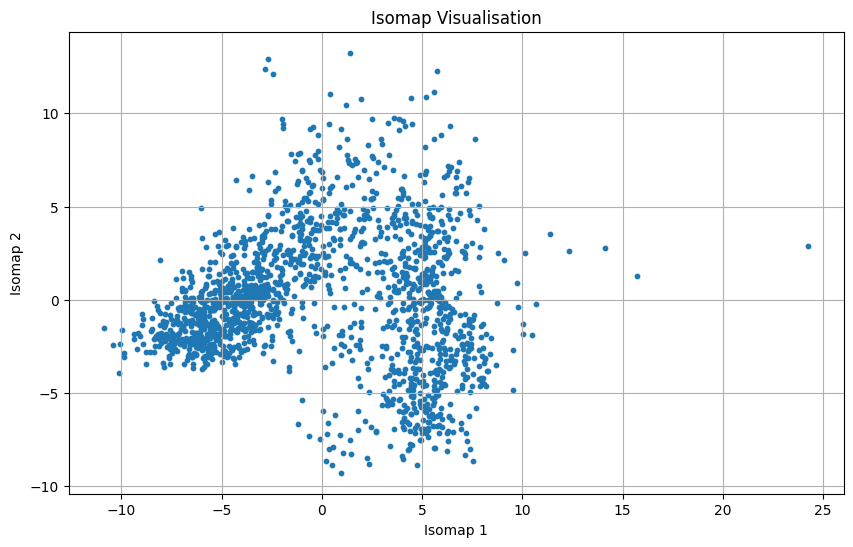

In [42]:
# What if I cluster the whole 18 dimensions 
# There is a technique called Isomap
# Perform Isomap on normalszed and standardised data
Climate_Basel_datframq = pd.read_csv("C:\Data\ClimateDataBasel.csv")
norm_full = normalise(Climate_Basel_datframq)
remove_outliers = find_outliers(norm_full)

stand_full = standardise(Climate_Basel_datframq)
removed_stand = find_outliers(stand_full)

isomap = perform_isomap(remove_outliers, n_components=2)
isomap_stand  = perform_isomap(removed_stand, n_components=2)

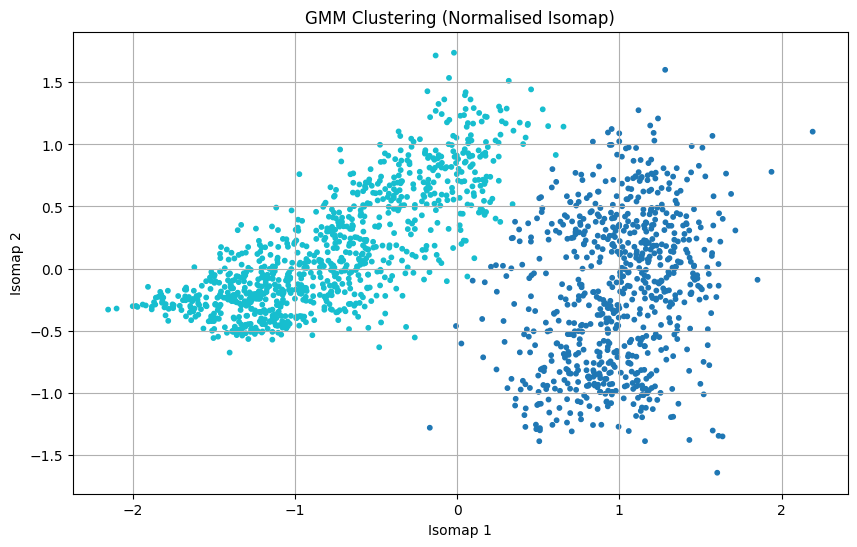

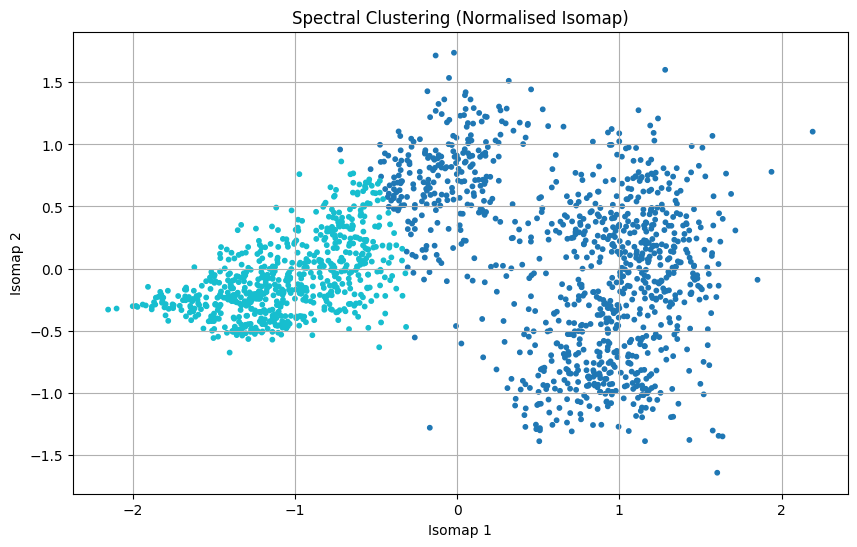

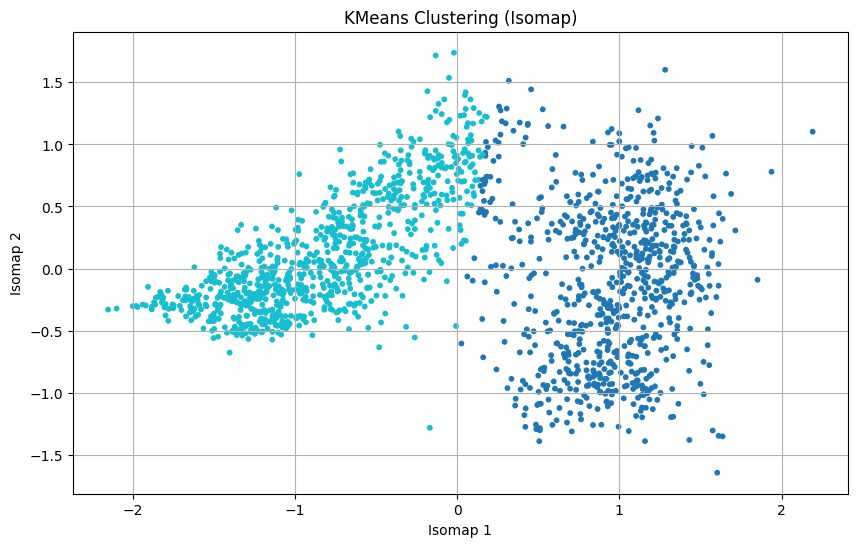

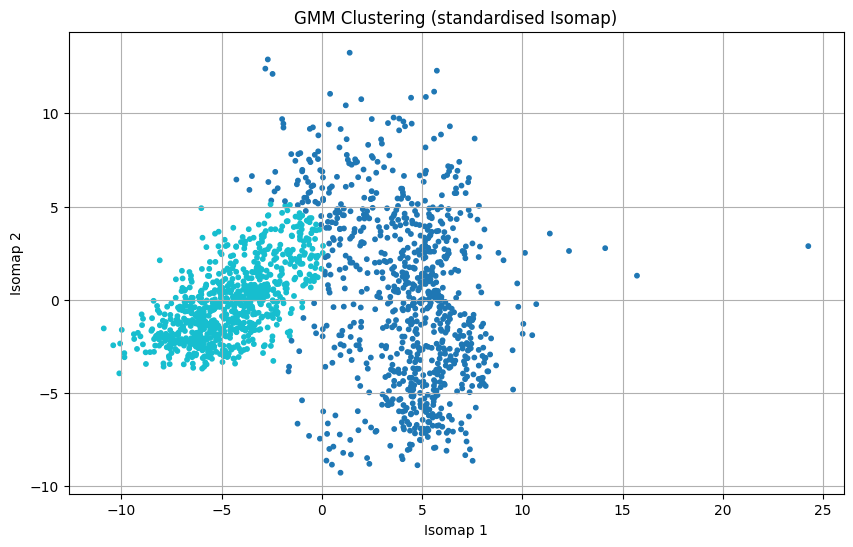

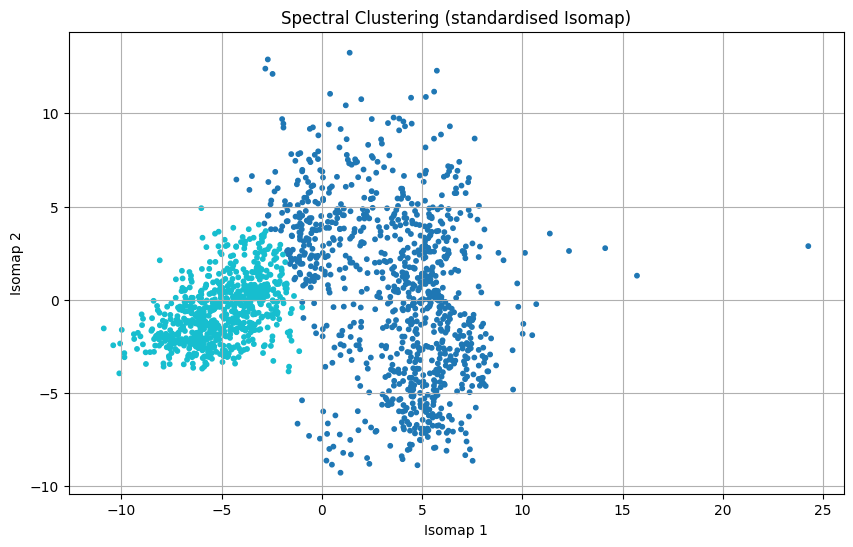

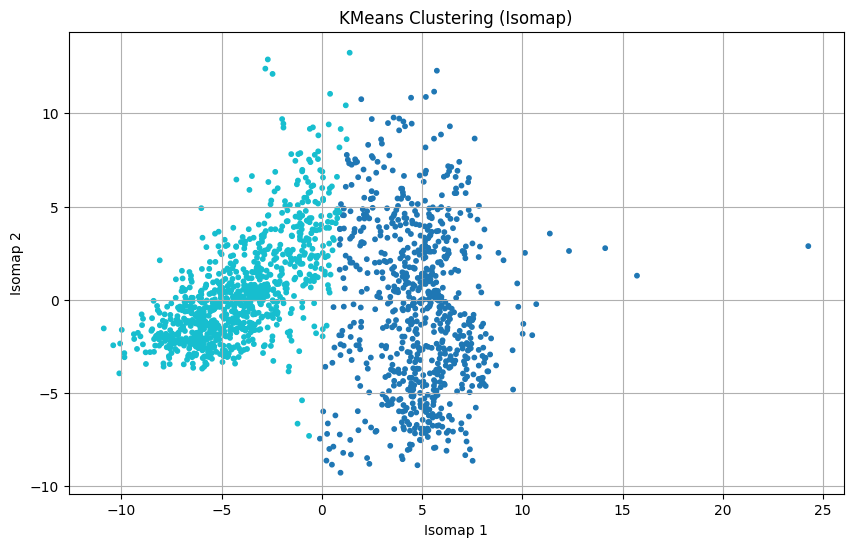

Silhouette Score for GMM (Isomap) : 0.545
Silhouette Score for Spectral (Isomap) : 0.511
Silhouette Score for KMeans (Isomap) : 0.544
Davies-Bouldin Index (GMM (Isomap)): 0.705
Davies-Bouldin Index (Spectral (Isomap)): 0.694
Davies-Bouldin Index (KMeans (Isomap)): 0.703
Silhouette Score for GMM (Isomap) stand : 0.478
Silhouette Score for Spectral (Isomap) stand : 0.464
Silhouette Score for KMeans (Isomap) stand : 0.496
Davies-Bouldin Index (GMM (Isomap) stand): 0.834
Davies-Bouldin Index (Spectral (Isomap) stand): 0.808
Davies-Bouldin Index (KMeans (Isomap) stand): 0.825


In [43]:
# Apply clustering on Isomap normalised data
spectral_isomap_n = Spectral(isomap, n_clusters=2)
kmeans_isomap_n = Kmeans(isomap, n_clusters=2)
gmm_isomap_n = GMM(isomap, n_clusters=2)


# Plot clusters for Isomap normalised data
plot_clusters(isomap, gmm_isomap_n, 'GMM Clustering (Normalised Isomap)', 'Isomap')
plot_clusters(isomap, spectral_isomap_n, 'Spectral Clustering (Normalised Isomap)', 'Isomap')
plot_clusters(isomap, kmeans_isomap_n, 'KMeans Clustering (Isomap)', 'Isomap')

# Plot clusters for Isomap standardised data
spectral_isomap_s = Spectral(isomap_stand, n_clusters=2)
kmeans_isomap_s = Kmeans(isomap_stand, n_clusters=2)
gmm_isomap_s = GMM(isomap_stand, n_clusters=2)


# Plot clusters for Isomap standardised data
plot_clusters(isomap_stand, gmm_isomap_s, 'GMM Clustering (standardised Isomap)', 'Isomap')
plot_clusters(isomap_stand, spectral_isomap_s, 'Spectral Clustering (standardised Isomap)', 'Isomap')
plot_clusters(isomap_stand, kmeans_isomap_s, 'KMeans Clustering (Isomap)', 'Isomap')

# Calculate silhouette scores for Isomap normalised data
sil_score(isomap, gmm_isomap_n, 'GMM (Isomap)')
sil_score(isomap, spectral_isomap_n, 'Spectral (Isomap)')
sil_score(isomap, kmeans_isomap_n, 'KMeans (Isomap)')

# Calculate db index for Isomap normalised data
db_index(isomap, gmm_isomap_n, 'GMM (Isomap)')
db_index(isomap, spectral_isomap_n, 'Spectral (Isomap)')
db_index(isomap, kmeans_isomap_n, 'KMeans (Isomap)')


# Calculate silhouette scores for Isomap normalised data
sil_score(isomap_stand, gmm_isomap_s, 'GMM (Isomap) stand')
sil_score(isomap_stand, spectral_isomap_s, 'Spectral (Isomap) stand')
sil_score(isomap_stand, kmeans_isomap_s, 'KMeans (Isomap) stand')

# Calculate db index for Isomap normalised data
db_index(isomap_stand, gmm_isomap_s, 'GMM (Isomap) stand')
db_index(isomap_stand, spectral_isomap_s, 'Spectral (Isomap) stand')
db_index(isomap_stand, kmeans_isomap_s, 'KMeans (Isomap) stand')


## UMAP

C:\Users\Mohammed Ameen Dasu\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\Mohammed Ameen Dasu\AppData\Local\Programs\Python\Python311\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


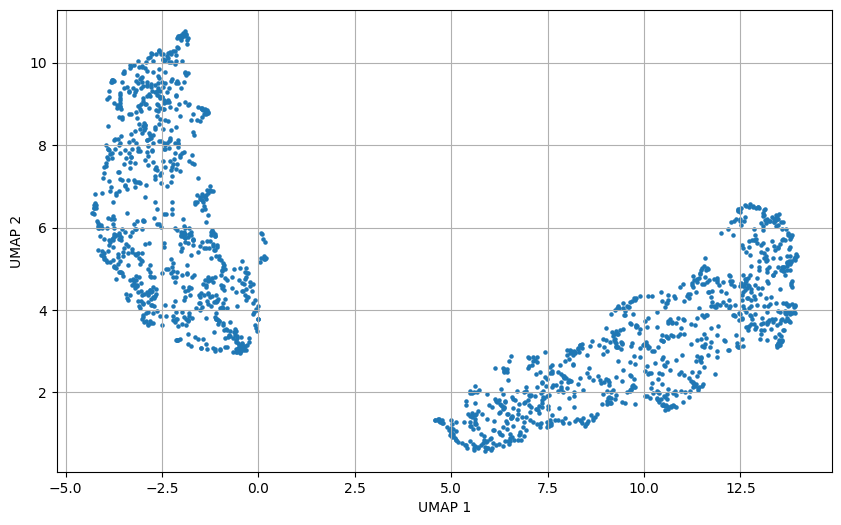

C:\Users\Mohammed Ameen Dasu\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\Mohammed Ameen Dasu\AppData\Local\Programs\Python\Python311\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


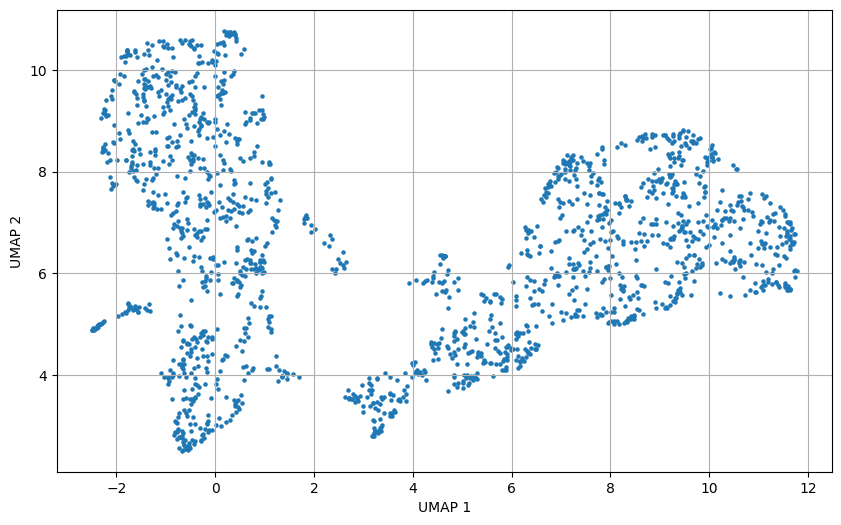

C:\Users\Mohammed Ameen Dasu\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\manifold\_spectral_embedding.py:329: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
C:\Users\Mohammed Ameen Dasu\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\manifold\_spectral_embedding.py:329: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


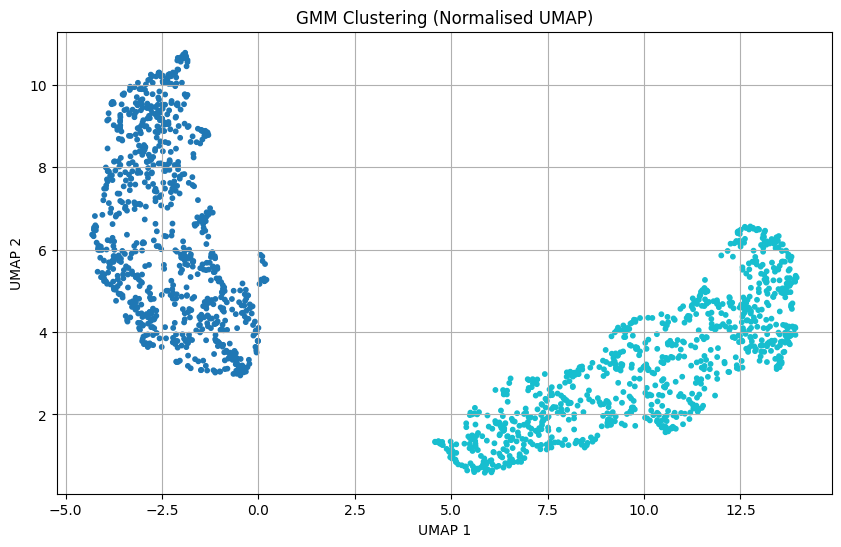

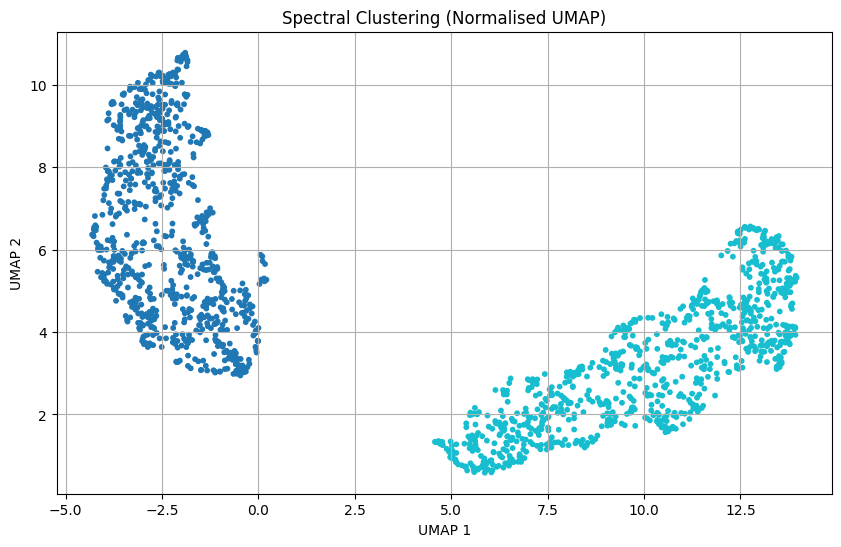

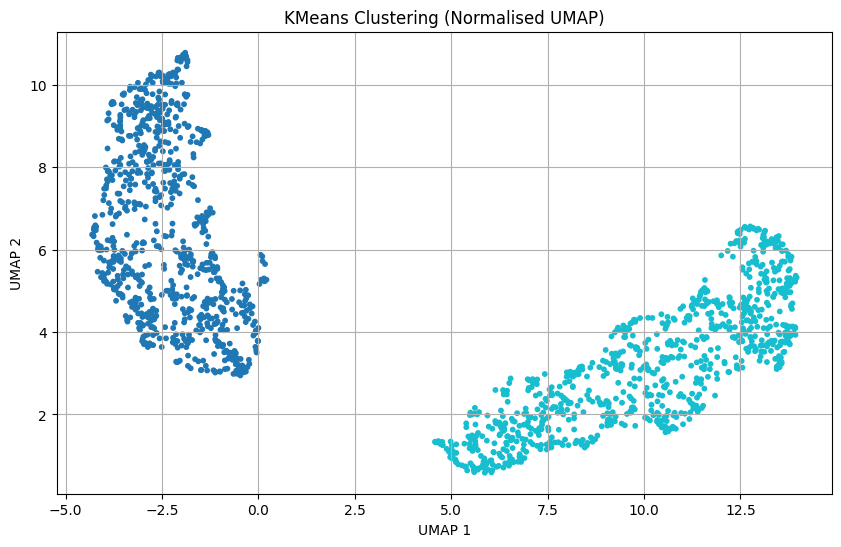

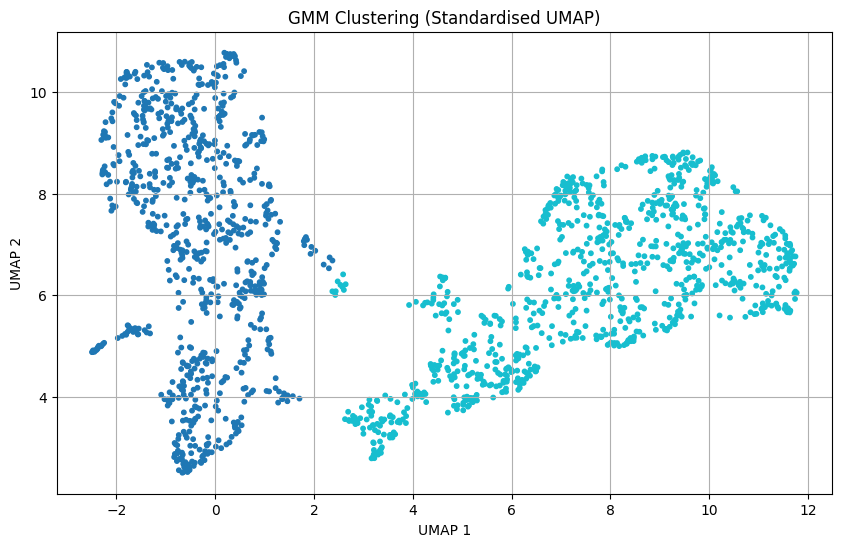

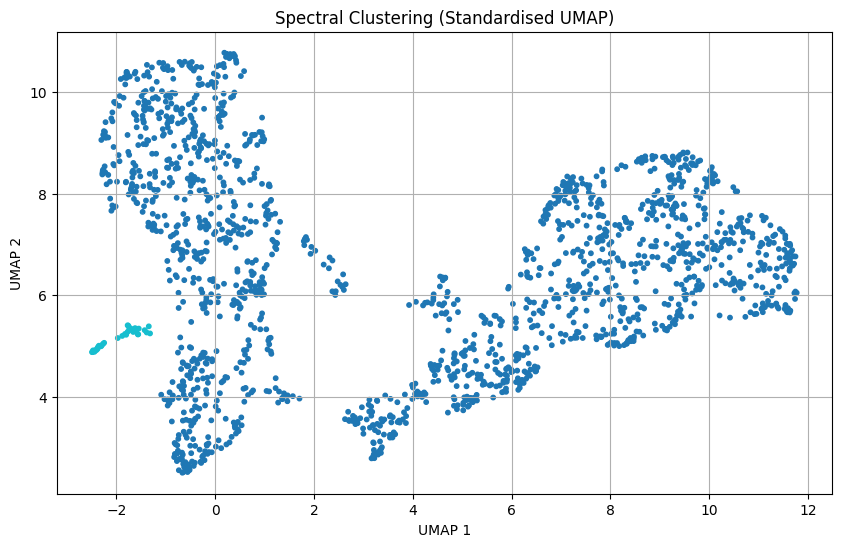

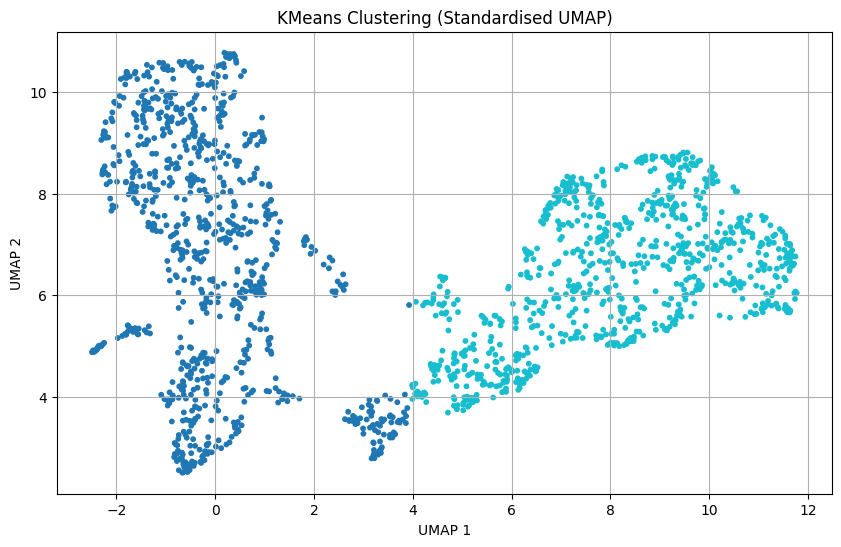

Silhouette Score for GMM (Normalised UMAP) : 0.731
Silhouette Score for Spectral (Normalised UMAP) : 0.731
Silhouette Score for KMeans (Normalised UMAP) : 0.731
Silhouette Score for GMM (Standardised UMAP) : 0.593
Silhouette Score for Spectral (Standardised UMAP) : 0.038
Silhouette Score for KMeans (Standardised UMAP) : 0.601
Davies-Bouldin Index (GMM (Normalised UMAP)): 0.399
Davies-Bouldin Index (Spectral (Normalised UMAP)): 0.399
Davies-Bouldin Index (KMeans (Normalised UMAP)): 0.399
Davies-Bouldin Index (GMM (Standardised UMAP)): 0.602
Davies-Bouldin Index (Spectral (Standardised UMAP)): 0.804
Davies-Bouldin Index (KMeans (Standardised UMAP)): 0.589


In [47]:
# Perform UMAP dimensionality reduction
norm = normalise(df_selected)
stnd = standardise(df_selected)


# performing Umap
UMAP_norm = umap_(norm)
UMAP_stnd = umap_(stnd)

# Spectral Clustering, KMeans, and GMM on UMAP normalised data
spectral_umap_n = Spectral(UMAP_norm, n_clusters=2)
kmeans_umap_n = Kmeans(UMAP_norm, n_clusters=2)
gmm_umap_n = GMM(UMAP_norm, n_clusters=2)

# Spectral Clustering, KMeans, and GMM on UMAP standardised data
spectral_umap_s = Spectral(UMAP_stnd, n_clusters=2)
kmeans_umap_s = Kmeans(UMAP_stnd, n_clusters=2)
gmm_umap_s = GMM(UMAP_stnd, n_clusters=2)


# Plot clusters for UMAP normalised data
plot_clusters(UMAP_norm.values, gmm_umap_n, 'GMM Clustering (Normalised UMAP)', 'UMAP')
plot_clusters(UMAP_norm.values, spectral_umap_n, 'Spectral Clustering (Normalised UMAP)', 'UMAP')
plot_clusters(UMAP_norm.values, kmeans_umap_n, 'KMeans Clustering (Normalised UMAP)', 'UMAP')

# Plot clusters for UMAP standardised data
plot_clusters(UMAP_stnd.values, gmm_umap_s, 'GMM Clustering (Standardised UMAP)', 'UMAP')
plot_clusters(UMAP_stnd.values, spectral_umap_s, 'Spectral Clustering (Standardised UMAP)', 'UMAP')
plot_clusters(UMAP_stnd.values, kmeans_umap_s, 'KMeans Clustering (Standardised UMAP)', 'UMAP')

# Calculate Silhouette Scores for UMAP normalised data
sil_score(UMAP_norm, gmm_umap_n, 'GMM (Normalised UMAP)')
sil_score(UMAP_norm, spectral_umap_n, 'Spectral (Normalised UMAP)')
sil_score(UMAP_norm, kmeans_umap_n, 'KMeans (Normalised UMAP)')

# Calculate Silhouette Scores for UMAP standardised data
sil_score(UMAP_stnd, gmm_umap_s, 'GMM (Standardised UMAP)')
sil_score(UMAP_stnd, spectral_umap_s, 'Spectral (Standardised UMAP)')
sil_score(UMAP_stnd, kmeans_umap_s, 'KMeans (Standardised UMAP)')


# Calculate Silhouette Scores for UMAP normalised data
db_index(UMAP_norm, gmm_umap_n, 'GMM (Normalised UMAP)')
db_index(UMAP_norm, spectral_umap_n, 'Spectral (Normalised UMAP)')
db_index(UMAP_norm, kmeans_umap_n, 'KMeans (Normalised UMAP)')

# Calculate Silhouette Scores for UMAP standardised data
db_index(UMAP_stnd, gmm_umap_s, 'GMM (Standardised UMAP)')
db_index(UMAP_stnd, spectral_umap_s, 'Spectral (Standardised UMAP)')
db_index(UMAP_stnd, kmeans_umap_s, 'KMeans (Standardised UMAP)')

# Fin